**You will write your code in this worksheet**

**YOUR CODE WILL BE CHECKED FOR PLAGIARISM**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Initial Setup**

1. First, you will setup your CoLab environment.

2. Then, you will authenticate a Google Drive client to download the file we will be processing in our Spark job.
Make sure to follow the interactive instructions.

3. Then, you will download the dataset `lastfm.csv` and store it in your drive.
Check the panel in your left to note if the dataset has downloaded correctly under the "Files" tab.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 199 kB 71.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=6dd35bb9b96aa70e75b429ec8ee282ac0ff5a98f944a447297687c57e198ae8f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_list = drive.ListFile({'q': "'1iUsSO-Fo5D5c0YX9_6RgA1cy4IK_Da4-' in parents"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

In [ ]:
id='1q7iH1KpSPEtd35NAOqvA35mikPhracDY'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('lastfm.csv')

***Check whether your dataset was downloaded and stored correctly***

## **From this point onwards, you are supposed to do the coding yourself. Refer the Exercise Sheet to carry out your analysis**

In [ ]:
#Modules not related to pyspark are imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {"grid.color":".5", "grid.linestyle": "-"})
sns.set_theme()
import plotly.express as px

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
#Importing Pyspark Related Modules
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.ml.fpm import FPGrowth

Creating the Spark **Entry** Session

In [ ]:
spark = SparkSession.builder.master("local").appName("lastfm_Project").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local appName=lastfm_Project>

In [ ]:
spark

In [ ]:
#Reading the lastfm data into pyspark as DataFrame and used persist() to store it IN MEMORY and reduced the execution time
spark_lastfm = spark.read.csv("/content/lastfm.csv", header=True, inferSchema=True)
spark_lastfm.persist()

DataFrame[user: int, artist: string, sex: string, country: string]

In [ ]:
#Displaying the first 5 rows of the dataset
spark_lastfm.show(5)

+----+--------------------+---+-------+
|user|              artist|sex|country|
+----+--------------------+---+-------+
|   1|red hot chili pep...|  f|Germany|
|   1|the black dahlia ...|  f|Germany|
|   1|           goldfrapp|  f|Germany|
|   1|    dropkick murphys|  f|Germany|
|   1|            le tigre|  f|Germany|
+----+--------------------+---+-------+
only showing top 5 rows



In [ ]:
spark_lastfm.take(5)

[Row(user=1, artist='red hot chili peppers', sex='f', country='Germany'),
 Row(user=1, artist='the black dahlia murder', sex='f', country='Germany'),
 Row(user=1, artist='goldfrapp', sex='f', country='Germany'),
 Row(user=1, artist='dropkick murphys', sex='f', country='Germany'),
 Row(user=1, artist='le tigre', sex='f', country='Germany')]

In [ ]:
#Showing the schema of the dataFrame in tree format along with columns name and Datatypes
spark_lastfm.printSchema()

root
 |-- user: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country: string (nullable = true)



In [ ]:
#getting the data columns
spark_lastfm.columns

['user', 'artist', 'sex', 'country']

In [ ]:
#To know the total numbers of rows in the dataset
spark_lastfm.count()


289955

In [ ]:
#This indicates the dataset contains some duplicates
spark_lastfm.distinct().count()

289953

In [ ]:
#Getting the numbers of columns
len(spark_lastfm.columns)

4

In [ ]:
#Showing the top row in a vertical view
spark_lastfm.show(1, vertical=True)

-RECORD 0-----------------------
 user    | 1                    
 artist  | red hot chili pep... 
 sex     | f                    
 country | Germany              
only showing top 1 row



In [ ]:
#Dropping the duplicates in the dataset
spark_lastfm = spark_lastfm.dropDuplicates()
spark_lastfm.show(5)

+----+--------------------+---+-------+
|user|              artist|sex|country|
+----+--------------------+---+-------+
|  19|            le tigre|  f| Sweden|
|  28|rage against the ...|  m| Sweden|
|  47|       john coltrane|  m|  Italy|
|  64|        trentemøller|  m| Poland|
|  74|             sirenia|  m|  Spain|
+----+--------------------+---+-------+
only showing top 5 rows



In [ ]:
#Count of the rows after dupplicates has been dropped.
spark_lastfm.count()

289953

In [ ]:
#To show summary of the dataFrame lastfm
spark_lastfm.select("user", "artist", "sex", "country").describe().show()

+-------+-----------------+--------------------+------+-----------+
|summary|             user|              artist|   sex|    country|
+-------+-----------------+--------------------+------+-----------+
|  count|           289953|              289953|289953|     289953|
|   mean|9852.470696975028|  178.03614457831324|  null|       null|
| stddev|5692.372170724096|   133.7678036793788|  null|       null|
|    min|                1|...and you will k...|     f|Afghanistan|
|    max|            19718|          Édith piaf|     m|   Zimbabwe|
+-------+-----------------+--------------------+------+-----------+



**Exploratory** **Analysis** **of** **the** **lastfm** **dataset** **using Spark SQL and other Pyhton libraries**

In [ ]:
spark_lastfm.createOrReplaceTempView("sql_lastfm")

In [ ]:
df = spark.sql("SELECT * FROM sql_lastfm").show()

+----+--------------------+---+------------------+
|user|              artist|sex|           country|
+----+--------------------+---+------------------+
|  19|            le tigre|  f|            Sweden|
|  28|rage against the ...|  m|            Sweden|
|  47|       john coltrane|  m|             Italy|
|  64|        trentemøller|  m|            Poland|
|  74|             sirenia|  m|             Spain|
|  97|         johnny cash|  m|     United States|
| 124|            anathema|  m|            Brazil|
| 129|          bloc party|  f|            Poland|
| 136|             madonna|  f|            Brazil|
| 138|       the offspring|  m|            Sweden|
| 173|         iron maiden|  m|         Australia|
| 191|        otis redding|  f|     United States|
| 202|     sarah mclachlan|  f|             Ghana|
| 213|               doves|  f|     United States|
| 224|            hot chip|  m|     United States|
| 256|       amy winehouse|  m|           Germany|
| 256|       blank & jones|  m|

In [ ]:
df1 =  spark.sql("SELECT COUNT(DISTINCT country) FROM sql_lastfm").show()
df2 = spark.sql("SELECT COUNT(DISTINCT artist) FROM sql_lastfm").show()
df3 = spark.sql("SELECT COUNT(DISTINCT sex) FROM sql_lastfm").show()
df4 = spark.sql("SELECT COUNT(DISTINCT user) FROM sql_lastfm").show()

+-----------------------+
|count(DISTINCT country)|
+-----------------------+
|                    159|
+-----------------------+

+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                  1004|
+----------------------+

+-------------------+
|count(DISTINCT sex)|
+-------------------+
|                  2|
+-------------------+

+--------------------+
|count(DISTINCT user)|
+--------------------+
|               15000|
+--------------------+



In [ ]:
df5 = spark.sql("SELECT DISTINCT user, sex, country FROM sql_lastfm").show()

+----+---+------------------+
|user|sex|           country|
+----+---+------------------+
| 360|  f|            Brazil|
| 434|  m|    United Kingdom|
| 854|  m|     United States|
|1446|  m|     United States|
|1578|  f|            Poland|
|1618|  m|            Brazil|
|1639|  f|            Greece|
|2025|  m|     United States|
|2077|  m|     United States|
|2168|  f|           Ireland|
|2587|  m|    United Kingdom|
|3742|  f|Russian Federation|
|4253|  m|            Mexico|
|4255|  m|             Japan|
|4739|  m|            France|
|5037|  f|    United Kingdom|
|5624|  m|Russian Federation|
|5823|  m|     United States|
|6582|  m|            Brazil|
|7055|  m|            Poland|
+----+---+------------------+
only showing top 20 rows



In [ ]:
df6 = spark.sql("SELECT DISTINCT artist FROM sql_lastfm").toPandas()
df6.head(10)

,artist
0,le tigre
1,the mountain goats
2,kate bush
3,lagwagon
4,godsmack
5,kmfdm
6,the beatles
7,dizzee rascal
8,calexico
9,gogol bordello


In [ ]:
df8 = spark.sql("SELECT DISTINCT user, sex, country FROM sql_lastfm").toPandas()
df8.head(10)

,user,sex,country
0,360,f,Brazil
1,434,m,United Kingdom
2,854,m,United States
3,1446,m,United States
4,1578,f,Poland
5,1618,m,Brazil
6,1639,f,Greece
7,2025,m,United States
8,2077,m,United States
9,2168,f,Ireland


In [ ]:
User_count = spark_lastfm.select("user").groupby("user").count().toPandas()
User_count.head()

,user,count
0,833,15
1,6466,36
2,6658,16
3,7880,28
4,10362,4


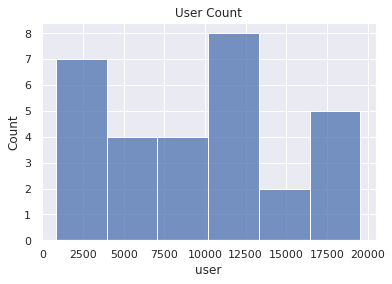

In [ ]:
palette = sns.color_palette("pastel")
sns.histplot(x='user',data=User_count.head(30), palette="pastel")
plt.title("User Count")
plt.savefig("User_count")

In [ ]:
#Converting the dataFrame to Pandas to be able to perfrom data visualization on it
dataFrame= spark_lastfm.select('user', 'artist','sex', 'country').toPandas()

In [ ]:
dataFrame.head(10)

,user,artist,sex,country
0,19,le tigre,f,Sweden
1,28,rage against the machine,m,Sweden
2,47,john coltrane,m,Italy
3,64,trentemøller,m,Poland
4,74,sirenia,m,Spain
5,97,johnny cash,m,United States
6,124,anathema,m,Brazil
7,129,bloc party,f,Poland
8,136,madonna,f,Brazil
9,138,the offspring,m,Sweden


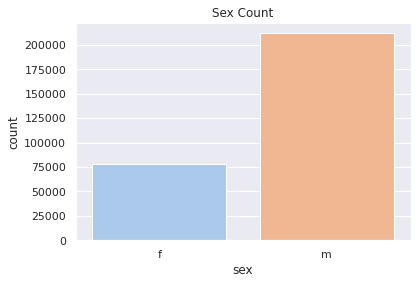

In [ ]:
#Sex count using seaborn
palette = sns.color_palette("pastel")
sns.countplot(x='sex',data=dataFrame, palette="pastel")
plt.title("Sex Count")
plt.savefig("Sex_count")

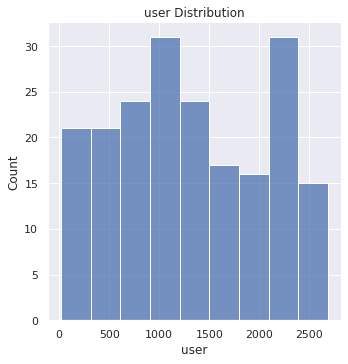

In [ ]:
#Visualizing the top 50 user distribution count using displot in seaborn
sns.displot(x='user',data=dataFrame.head(200), palette="bright")
plt.title("user Distribution")
plt.savefig("Sex_count")

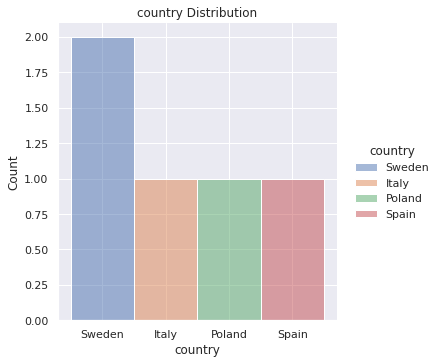

In [ ]:
#Using the displot in seaborn to visually show the country distribution
sns.displot(x='country',data=dataFrame.head(), hue="country")
plt.title("country Distribution")
plt.savefig("Country_distribution")

In [ ]:
#Getting the count of user by artist using barchart in plotly
figure = px.bar(dataFrame.head(5), x="artist",color="user", title="Artist by User")
figure.show()

In [ ]:
#Visually displaying the country and count of user in the country
figure = px.sunburst(dataFrame.head(20), path=['country'], values='user',
                  color='artist', hover_data=['user'], title="Countries per User Count")
figure.show()

In [ ]:
Average_user = spark_lastfm.groupBy('country', 'sex').avg('user').sort('country').toPandas()

In [ ]:
Average_user.head(10)

,country,sex,avg(user)
0,Afghanistan,m,2131.000000
1,Afghanistan,f,8944.000000
2,Albania,f,6767.000000
3,Albania,m,18710.441860
4,Algeria,m,1452.000000
5,Algeria,f,11928.000000
6,American Samoa,m,6434.000000
7,Andorra,m,14560.272727
8,Angola,m,3239.000000
9,Antarctica,m,9500.830601


In [ ]:
#Average User by Country and Sex
figure = px.bar(Average_user.head(40), x=["country", "sex"], y="avg(user)", color="country",
                title="Average User by Country & Sex",
                hover_data=["avg(user)"])
figure.show()

## **FP Growth Algorithm Prediction Analysis**

In [ ]:
grouped_spark_lastfm = spark_lastfm.groupBy('user').agg({'artist': 'collect_list'})

In [ ]:
grouped_spark_lastfm=grouped_spark_lastfm.toDF("user", "artist")

In [ ]:
grouped_spark_lastfm.take(5)

[Row(user=1, artist=['eluveitie', 'the who', 'edguy', 'jack johnson', 'le tigre', 'rob zombie', 'guano apes', 'goldfrapp', 'dropkick murphys', 'the rolling stones', 'judas priest', 'schandmaul', 'the black dahlia murder', 'john mayer', 'red hot chili peppers', 'the killers']),
 Row(user=3, artist=['pavement', 'mf doom', 'devendra banhart', 'broken social scene', 'm83', 'four tet', 'the flashbulb', 'animal collective', 'aesop rock', 'beastie boys', 'air', 'cocorosie', 'aphex twin', 'amon tobin', 'portishead', 'neutral milk hotel', 'sage francis', 'boards of canada', 'goldfrapp', 'radiohead', 'autechre', 'atmosphere', 'massive attack', 'plaid', 'joanna newsom', 'prefuse 73', 'arcade fire', 'max richter', 'the books']),
 Row(user=4, artist=['the flaming lips', 'a tribe called quest', 'mgmt', 'simian mobile disco', 'dj shadow', 'late of the pier', 'pink floyd', 'beck', 'bonobo', 'tv on the radio', 'battles', 'the decemberists', 'tool', 'the rolling stones', 'the cinematic orchestra', 'led 

In [ ]:
grouped_spark_lastfm.show(5)

+----+--------------------+
|user|              artist|
+----+--------------------+
|   1|[eluveitie, the w...|
|   3|[pavement, mf doo...|
|   4|[the flaming lips...|
|   5|[dream theater, m...|
|   6|[muse, dream thea...|
+----+--------------------+
only showing top 5 rows



In [ ]:
#Dataset spliting into train and test dataset
train, test = grouped_spark_lastfm.randomSplit(weights=[0.7, 0.3], seed=100)

In [ ]:
print(train.count())
print(test.count())

10534
4466


### **First Tuning the Hyper parameter to get the better Optimal combination for lift**

In [ ]:

lastfm_fp_growth = FPGrowth(itemsCol="artist", minSupport=0.01, minConfidence=0.3)
lastfm_model = lastfm_fp_growth.fit(train)

In [ ]:
print(lastfm_model.freqItemsets.count())
print(lastfm_model.associationRules.count())

1688
487


In [ ]:
lastfm_model.freqItemsets.take(5)

[Row(items=['3 doors down'], freq=336),
 Row(items=['3 doors down', 'linkin park'], freq=114),
 Row(items=['van morrison'], freq=126),
 Row(items=['megadeth'], freq=324),
 Row(items=['megadeth', 'metallica'], freq=172)]

In [ ]:
Viz_lastfm_model= lastfm_model.freqItemsets.orderBy("freq", ascending=False).toPandas()

In [ ]:
Viz_lastfm_model.head()

,items,freq
0,[radiohead],1925
1,[the beatles],1856
2,[coldplay],1662
3,[red hot chili peppers],1211
4,[muse],1190


In [ ]:
print(lastfm_model.associationRules.count())

487


In [ ]:
print(lastfm_model.associationRules.show())

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|               [nas]|             [jay-z]|0.44106463878326996|14.252070260561245| 0.01101196126827416|
|               [nas]|        [kanye west]|0.45627376425855515| 6.905729644683362|0.011391684070628441|
|[the smashing pum...|         [radiohead]| 0.4795144157814871| 2.624002522515421| 0.02999810138598823|
|[snow patrol, rad...|          [coldplay]| 0.6385542168674698| 4.047250373334492|0.010062654262388457|
|[belle and sebast...|       [the beatles]|0.34674329501915707|1.9679923867089442|0.017182456806531233|
|[belle and sebast...|         [radiohead]|0.42528735632183906|2.3272607851918194|0.021074615530662616|
| [simon & garfunkel]|       [the beatles]| 0.5078369905956113| 

In [ ]:
#The optimal lift for the combination of support and confidence
df = print(lastfm_model.associationRules.orderBy("lift", ascending=False).toPandas().head())

             antecedent consequent  confidence      lift   support
0                 [nas]    [jay-z]    0.441065  14.25207  0.011012
1               [jay-z]      [nas]    0.355828  14.25207  0.011012
2  [the pussycat dolls]  [rihanna]    0.563830  12.66393  0.010063
3             [rihanna]  [beyoncé]    0.313433  10.65065  0.013955
4             [beyoncé]  [rihanna]    0.474194  10.65065  0.013955


In [ ]:
lastfm_new_output = lastfm_model.transform(test)

In [ ]:
lastfm_new_output

DataFrame[user: int, artist: array<string>, prediction: array<string>]

In [ ]:
lastfm_new_output.take(5)

[Row(user=5, artist=['dream theater', 'megadeth', 'volbeat', 'iron maiden', 'children of bodom', 'sublime', 'nightwish', 'metallica', 'ac/dc', 'bob marley & the wailers', 'trivium'], prediction=['in flames']),
 Row(user=18, artist=['fleetwood mac', 'sonata arctica', 'creedence clearwater revival', 'aphex twin', 'mindless self indulgence', 'infected mushroom', 'nightwish', 'john williams', 'electric light orchestra', 'iron maiden', 'michael jackson'], prediction=['boards of canada', 'radiohead', 'metallica']),
 Row(user=19, artist=['bloc party', 'bob marley & the wailers', 'n*e*r*d', 'placebo', 'coldplay', 'the kooks', 'klaxons', 'portishead', 'cut copy', 'the radio dept.', 'thom yorke', 'josé gonzález', 'crystal castles', 'múm', 'sex pistols', 'yo la tengo', 'interpol', 'håkan hellström', 'beirut', 'fischerspooner', 'the postal service', 'a perfect circle', 'beck', 'röyksopp', 'nine inch nails', 'animal collective', 'gorillaz', 'nouvelle vague', 'the kills', 'sonic youth', 'franz ferdi

In [ ]:
lastfm_new_output.show(5)

+----+--------------------+--------------------+
|user|              artist|          prediction|
+----+--------------------+--------------------+
|   5|[dream theater, m...|         [in flames]|
|  18|[fleetwood mac, s...|[boards of canada...|
|  19|[bloc party, bob ...|[radiohead, muse,...|
|  23|[jamiroquai, ramo...|[daft punk, coldp...|
|  24|[the rolling ston...|[radiohead, bob d...|
+----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
lastfm_new_output.toPandas().head() #The new output coverted to pandas for better visualization

,user,artist,prediction
0,5,"[dream theater, megadeth, volbeat, iron maiden...",[in flames]
1,18,"[fleetwood mac, sonata arctica, creedence clea...","[boards of canada, radiohead, metallica]"
2,19,"[bloc party, bob marley & the wailers, n*e*r*d...","[radiohead, muse, tool, the killers, arctic mo..."
3,23,"[jamiroquai, ramones, franz ferdinand, the kin...","[daft punk, coldplay, muse, the killers, arcti..."
4,24,"[the rolling stones, bruce springsteen, johnny...","[radiohead, bob dylan, led zeppelin]"
5,31,"[róisín murphy, jamie cullum, thievery corpora...","[the cure, the beatles, portishead]"
6,32,"[leonard cohen, peaches, misfits, Édith piaf, ...","[the beatles, radiohead, pink floyd]"
7,38,"[the beatles, adele, elton john, john legend, ...","[coldplay, radiohead, britney spears, rihanna]"
8,42,"[avril lavigne, evanescence, nightwish, as i l...",[linkin park]
9,47,"[tom waits, kate bush, david bowie, johnny cas...","[the beatles, coldplay, massive attack, the ro..."


### **2. Tuning the Hyper parameter the second time to get the better Optimal combination for lift**

In [ ]:
#Second Parameters Tuning- changed the minConfidence
lastfm_fp_growth_2 = FPGrowth(itemsCol="artist", minSupport=0.02, minConfidence=0.1)
lastfm_model_2 = lastfm_fp_growth_2.fit(train)

In [ ]:
print(lastfm_model_2.freqItemsets.count())
print(lastfm_model_2.associationRules.count())

405


In [ ]:
lastfm_model_2.freqItemsets.take(5)

In [ ]:
Viz_lastfm_model_2= lastfm_model_2.freqItemsets.orderBy("freq", ascending=False).toPandas()

In [ ]:
Viz_lastfm_model_2.head(20)

,items,freq
0,[radiohead],1925
1,[the beatles],1856
2,[coldplay],1662
3,[red hot chili peppers],1211
4,[muse],1190


In [ ]:
print(lastfm_model_2.associationRules.show())

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|[red hot chili pe...|         [green day]|0.18166804293971925|2.6001238645747318|0.020884754129485476|
|[red hot chili pe...|           [nirvana]|0.24277456647398843| 2.492580198086739| 0.02790962597303968|
|[red hot chili pe...|      [foo fighters]|0.21139554087530965|2.8733427452651763|0.024302259350674007|
|[red hot chili pe...|         [metallica]| 0.2213047068538398|  2.06302989557376| 0.02544142775773685|
|[red hot chili pe...|              [muse]|0.23038810900082576| 2.039418773289663|0.026485665464211126|
|[red hot chili pe...|  [system of a down]|0.22213047068538397|2.4527488241088413| 0.02553635845832542|
|[red hot chili pe...|       [linkin park]|0.21469859620148637| 

In [ ]:
df_2 = print(lastfm_model_2.associationRules.orderBy("lift", ascending=False).toPandas().head())

              antecedent             consequent  confidence      lift  \
0           [portishead]       [massive attack]    0.335294  5.089320   
1       [massive attack]           [portishead]    0.328530  5.089320   
2            [the shins]  [death cab for cutie]    0.415270  5.005097   
3  [death cab for cutie]            [the shins]    0.255149  5.005097   
4                 [koЯn]     [system of a down]    0.445283  4.916783   

    support  
0  0.021644  
1  0.021644  
2  0.021170  
3  0.021170  
4  0.022404  


In [ ]:
lastfm_new_output_2 = lastfm_model_2.transform(test)

In [ ]:
lastfm_new_output_2

DataFrame[user: int, artist: array<string>, prediction: array<string>]

In [ ]:
lastfm_new_output_2.take(5)

[Row(user=5, artist=['dream theater', 'megadeth', 'volbeat', 'iron maiden', 'children of bodom', 'sublime', 'nightwish', 'metallica', 'ac/dc', 'bob marley & the wailers', 'trivium'], prediction=['nirvana', 'rammstein', 'the beatles', 'red hot chili peppers', 'system of a down', 'pink floyd']),
 Row(user=18, artist=['fleetwood mac', 'sonata arctica', 'creedence clearwater revival', 'aphex twin', 'mindless self indulgence', 'infected mushroom', 'nightwish', 'john williams', 'electric light orchestra', 'iron maiden', 'michael jackson'], prediction=['metallica']),
 Row(user=19, artist=['bloc party', 'bob marley & the wailers', 'n*e*r*d', 'placebo', 'coldplay', 'the kooks', 'klaxons', 'portishead', 'cut copy', 'the radio dept.', 'thom yorke', 'josé gonzález', 'crystal castles', 'múm', 'sex pistols', 'yo la tengo', 'interpol', 'håkan hellström', 'beirut', 'fischerspooner', 'the postal service', 'a perfect circle', 'beck', 'röyksopp', 'nine inch nails', 'animal collective', 'gorillaz', 'nouve

In [ ]:
lastfm_new_output_2.show(5)

+----+--------------------+--------------------+
|user|              artist|          prediction|
+----+--------------------+--------------------+
|   5|[dream theater, m...|[nirvana, rammste...|
|  18|[fleetwood mac, s...|         [metallica]|
|  19|[bloc party, bob ...|[the killers, rad...|
|  23|[jamiroquai, ramo...|[the beatles, bob...|
|  24|[the rolling ston...|[bob dylan, coldp...|
+----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
lastfm_new_output_2.toPandas().head(20)

,user,artist,prediction
0,5,"[dream theater, megadeth, volbeat, iron maiden...","[nirvana, rammstein, the beatles, red hot chil..."
1,18,"[fleetwood mac, sonata arctica, creedence clea...",[metallica]
2,19,"[bloc party, bob marley & the wailers, n*e*r*d...","[the killers, radiohead, jack johnson, keane, ..."
3,23,"[jamiroquai, ramones, franz ferdinand, the kin...","[the beatles, bob dylan, coldplay, the killers..."
4,24,"[the rolling stones, bruce springsteen, johnny...","[bob dylan, coldplay, pink floyd, nirvana, the..."
5,31,"[róisín murphy, jamie cullum, thievery corpora...","[sufjan stevens, portishead, the shins, nirvan..."
6,32,"[leonard cohen, peaches, misfits, Édith piaf, ...",[the beatles]
7,38,"[the beatles, adele, elton john, john legend, ...","[the rolling stones, nirvana, johnny cash, the..."
8,42,"[avril lavigne, evanescence, nightwish, as i l...",[]
9,47,"[tom waits, kate bush, david bowie, johnny cas...","[the rolling stones, the beatles, the smiths, ..."


### 3. **Tuning** the Hyper parameter the third time to get the better Optimal combination for lift**

In [ ]:
lastfm_fp_growth_3 = FPGrowth(itemsCol="artist", minSupport=0.01, minConfidence=0.2)
lastfm_model_3 = lastfm_fp_growth_3.fit(train)

In [ ]:
print(lastfm_model_3.freqItemsets.count())
print(lastfm_model_3.associationRules.count())

1688
1096


In [ ]:
lastfm_model_3.freqItemsets.take(5)

[Row(items=['3 doors down'], freq=336),
 Row(items=['3 doors down', 'linkin park'], freq=114),
 Row(items=['van morrison'], freq=126),
 Row(items=['megadeth'], freq=324),
 Row(items=['megadeth', 'metallica'], freq=172)]

In [ ]:
Viz_lastfm_model_3= lastfm_model_3.freqItemsets.orderBy("freq", ascending=False).toPandas()

In [ ]:
Viz_lastfm_model_3.head()

,items,freq
0,[radiohead],1925
1,[the beatles],1856
2,[coldplay],1662
3,[red hot chili peppers],1211
4,[muse],1190


In [ ]:
print(lastfm_model_3.associationRules.show())

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|               [nas]|             [jay-z]|0.44106463878326996|14.252070260561245| 0.01101196126827416|
|               [nas]|        [kanye west]|0.45627376425855515| 6.905729644683362|0.011391684070628441|
|[the smashing pum...|          [the cure]|0.23823975720789076|3.1331056210086405|0.014904119992405544|
|[the smashing pum...|           [nirvana]| 0.2534142640364188| 2.601818574424596| 0.01585342699829125|
|[the smashing pum...|          [coldplay]| 0.2746585735963581|1.7408263623730662|0.017182456806531233|
|[the smashing pum...|      [foo fighters]|0.22306525037936267|3.0319604483822014| 0.01395481298651984|
|[the smashing pum...|           [placebo]|0.20637329286798178|2

In [ ]:
df_3 = print(lastfm_model_3.associationRules.orderBy("lift", ascending=False).toPandas().head())

             antecedent            consequent  confidence      lift   support
0                 [nas]               [jay-z]    0.441065  14.25207  0.011012
1               [jay-z]                 [nas]    0.355828  14.25207  0.011012
2             [rihanna]  [the pussycat dolls]    0.226013  12.66393  0.010063
3  [the pussycat dolls]             [rihanna]    0.563830  12.66393  0.010063
4             [rihanna]             [beyoncé]    0.313433  10.65065  0.013955


In [ ]:
lastfm_new_output_3 = lastfm_model_3.transform(test)

In [ ]:
lastfm_new_output_3

DataFrame[user: int, artist: array<string>, prediction: array<string>]

In [ ]:
lastfm_new_output_3.take(5)

[Row(user=5, artist=['dream theater', 'megadeth', 'volbeat', 'iron maiden', 'children of bodom', 'sublime', 'nightwish', 'metallica', 'ac/dc', 'bob marley & the wailers', 'trivium'], prediction=['in flames', 'nirvana', 'the beatles', 'red hot chili peppers', 'system of a down', 'rammstein', 'linkin park', 'evanescence', 'sonata arctica', 'queen', 'led zeppelin', 'pink floyd', 'black sabbath', 'judas priest']),
 Row(user=18, artist=['fleetwood mac', 'sonata arctica', 'creedence clearwater revival', 'aphex twin', 'mindless self indulgence', 'infected mushroom', 'nightwish', 'john williams', 'electric light orchestra', 'iron maiden', 'michael jackson'], prediction=['rammstein', 'metallica', 'system of a down', 'linkin park', 'evanescence', 'coldplay', 'the beatles', 'boards of canada', 'radiohead', 'megadeth', 'black sabbath', 'ac/dc', 'led zeppelin', 'pink floyd', 'judas priest']),
 Row(user=19, artist=['bloc party', 'bob marley & the wailers', 'n*e*r*d', 'placebo', 'coldplay', 'the kook

In [ ]:
lastfm_new_output_3.show(5)

+----+--------------------+--------------------+
|user|              artist|          prediction|
+----+--------------------+--------------------+
|   5|[dream theater, m...|[in flames, nirva...|
|  18|[fleetwood mac, s...|[rammstein, metal...|
|  19|[bloc party, bob ...|[radiohead, muse,...|
|  23|[jamiroquai, ramo...|[massive attack, ...|
|  24|[the rolling ston...|[bob dylan, radio...|
+----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
lastfm_new_output_3.toPandas().head(50)

,user,artist,prediction
0,5,"[dream theater, megadeth, volbeat, iron maiden...","[in flames, nirvana, the beatles, red hot chil..."
1,18,"[fleetwood mac, sonata arctica, creedence clea...","[rammstein, metallica, system of a down, linki..."
2,19,"[bloc party, bob marley & the wailers, n*e*r*d...","[radiohead, muse, tool, the strokes, the kille..."
3,23,"[jamiroquai, ramones, franz ferdinand, the kin...","[massive attack, air, daft punk, moby, the pro..."
4,24,"[the rolling stones, bruce springsteen, johnny...","[bob dylan, radiohead, david bowie, u2, led ze..."
5,31,"[róisín murphy, jamie cullum, thievery corpora...","[the cure, the beatles, david bowie, morrissey..."
6,32,"[leonard cohen, peaches, misfits, Édith piaf, ...","[the beatles, bob dylan, david bowie, radiohea..."
7,38,"[the beatles, adele, elton john, john legend, ...","[coldplay, radiohead, pink floyd, britney spea..."
8,42,"[avril lavigne, evanescence, nightwish, as i l...","[coldplay, system of a down, linkin park, iron..."
9,47,"[tom waits, kate bush, david bowie, johnny cas...","[the beatles, coldplay, the rolling stones, th..."
